<a href="https://colab.research.google.com/github/nadnik13/sparse_grid/blob/main/GPU_Simple_Cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import sys
from numba import cuda

In [34]:
grid_a = np.random.sample(297)
grid_b = np.random.sample(297)*3

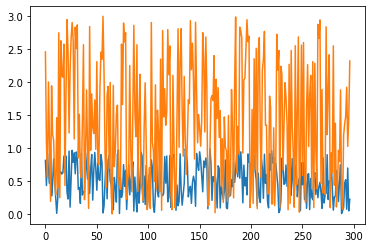

In [35]:
plt.plot(grid_a)
plt.plot(grid_b)
plt.show()

In [37]:
from numba import cuda # Библиотека Nvidia для работы с GPU 
import numpy as np 

@cuda.jit('float64(float64)', device=True)
def phi_1(x):
    if -1 <= x <= 1:
        return 1 - abs(x)
    return 0

@cuda.jit('void(float64[:], float64[:], float64[:])') #Динамический компилятор Cuda 
def cuda_addition(d_a,d_b,d_c):
    """Поток будет выполнять эту функцию ядра."""
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # Отображение потока на индекс массива
    if (i >= d_c.size):
      return
    d_c[i] = phi_1(3) #Perform the addition
 
# Подробности об устройстве
device = cuda.get_current_device()
n = 297
# Перенос с хоста на устройство
d_a = cuda.to_device(grid_a)  # Перенос данных в глобальную память GPU
d_b = cuda.to_device(grid_b)  # Перенос данных в глобальную память GPU
d_c = cuda.device_array_like(grid_a)

tpb = device.WARP_SIZE       #blocksize или количество потоков на блок, стандартное значение = 32
bpg = int(np.ceil((n)/tpb))  # блоков на грид

cuda_addition[bpg, tpb](d_a, d_b, d_c) # вызов ядра

# Перенос вывода с устройства на хост
c = d_c.copy_to_host()

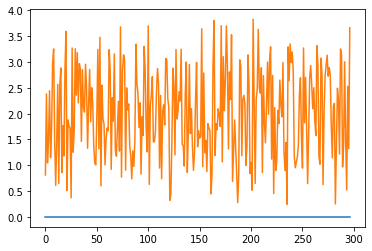

In [5]:
plt.plot(c)
plt.plot(grid_a + grid_b)
plt.show()

# Create GRID

d = 1 пробуем реализовать

In [36]:
fdim = 1
grid_level = 7
n_points = 100
grid_type = "full"

In [1]:
@cuda.jit('float64(float64)', device=True)
def fun_gpu(x):
    return math.sin(10 * x - 0.1)

def fun_cpu(x):
  print("func:", x)
  return math.sin(10 * x - 0.1)

NameError: ignored

In [16]:
def fun_cpu(x):
  return math.sin(10 * x - 0.1)

In [8]:
@cuda.jit('float64(int32, int32)', device=True)
def xli_gpu(l, i):
    return i * (2. ** (-l))


In [10]:
def xli_cpu(l, i):
    return i * (2. ** (-l))

In [10]:
@cuda.jit('float64(float64)', device=True)
def phi_1_gpu(x):
    if -1 <= x <= 1:
        return 1 - abs(x)
    return 0
@cuda.jit('float64(float64)', device=True)
def phi_2_gpu(x):
    if -1 <= x <= 1:
        return - (x-1)*(x+1)
    return 0

@cuda.jit('float64(int32, int32, float64)', device=True)
def phi_li_gpu(l, i, x):
    if l == 0:
        return phi_1_gpu(x * 2. ** l - i)
    else:
        return phi_2_gpu(x * 2. ** l - i)

In [5]:
def add_a(e):
    e['a'] = fun_cpu(xli_cpu(e['l'], e['i']))
#     print(f"add_a: i={e['i']} l={e['l']} e['i'] // 4={e['i'] % 4} e['i'] // 3={e['i'] % 3}")
    if e['l'] == 1:
        e['a'] += -0.5 * (fun_cpu(xli_cpu(e['l'], e['i']- 1)) + fun_cpu(xli_cpu(e['l'], e['i'] + 1)))
    elif (e['i'] % 4 == 1 and e['l'] > 1):
        e['a'] += -0.125 * (3*fun_cpu(xli_cpu(e['l'], e['i'] - 1)) + 6*fun_cpu(xli_cpu(e['l'], e['i'] + 1)) - fun_cpu(xli_cpu(e['l'], e['i'] + 3)))
    elif (e['i'] % 4 == 3 and e['l'] > 1):
        e['a'] += -0.125 * (3*fun_cpu(xli_cpu(e['l'], e['i'] + 1)) + 6*fun_cpu(xli_cpu(e['l'], e['i'] - 1)) - fun_cpu(xli_cpu(e['l'], e['i'] - 3)))
#     print(f"a = {e['a']}")
    # print(f"e['l']={e['l']} e['i']={e['i']} a_recursion={e['a']}")
    return e

# Generate grid

In [14]:
def buildGrid(grid_level):
    grid=[]


    grid = [add_a({'l': 1, 'i': 1})]
    for e in grid:
      if e['l'] == grid_level: #or abs(e['a']) < 1e-3:
          continue
      grid.append(add_a({'l': e['l'] + 1, 'i': 2 * e['i'] - 1}))
      grid.append(add_a({'l': e['l'] + 1, 'i': 2 * e['i'] + 1}))

    grid.append(add_a({'l': 0, 'i': 0}))
    grid.append(add_a({'l': 0, 'i': 1}))
    return grid.copy()

Параллельное вычисление функции на гриде

In [ ]:
@cuda.jit('float64[:, :], int32[:,:])')
def func_gpu(func_xli):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # Отображение потока на индекс массива
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y # Отображение потока на индекс массива
    if (i >= x.shape[0]) or (j >= x.shape[1]):
      return

    func_xli[i][j] = func_gpu(xli_gpu(i, j))

In [ ]:
max_l = grid_level
max_i = 2**grid_level + 1

d_points = cuda.device_array_like(np.zeros(max_l, max_i))

tpb = (32, 32)  #blocksize или количество потоков на блок, стандартное значение = 32
bpg = (int(np.ceil((n[0])/tpb[0])), int(np.ceil((n[1])/tpb[1])) )  # блоков на грид

func_gpu[bpg, tpb](d_points) # вызов ядра

# Перенос вывода с устройства на хост
points = d_points.copy_to_host()

In [ ]:
buildGrid(3)

In [14]:
def prepareGrid(grid, fdim):
  grid_l = []
  grid_i = []
  grid_a = []

  for i in grid:
    grid_l.append(i['l'])
    grid_i.append(i['i'])
    grid_a.append(i['a'])
  
  grid_l = np.array(grid_l)
  grid_i = np.array(grid_i)
  grid_a = np.array(grid_a)

  if fdim > 1:
    grid_l = grid_l.reshape(-1,fdim)
    grid_i = grid_i.reshape(-1,fdim)
    grid_a = grid_a.reshape(-1,fdim)
  return grid_l, grid_i, grid_a


In [35]:
grid = buildGrid(grid_level, grid_type)
grid_l, grid_i, grid_a = prepareGrid(grid,1)

In [20]:
grid_l, grid_i, grid_a = prepareGrid(grid,1)
grid_l.shape, grid_i.shape, grid_a.shape

((705, 3), (705, 3), (705,))

In [17]:
@cuda.jit('void(int32[:], int32[:], float64[:], float64[:, :], float64[:])')
def eval_gpu(grid_l, grid_i, grid_a, r, x):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # Отображение потока на индекс массива
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y # Отображение потока на индекс массива
    if (i >= r.size):
      return
    r[i][j] = grid_a[j] * phi_li_gpu(grid_l[j], grid_i[j], x[i])


In [31]:
from numba import cuda # Библиотека Nvidia для работы с GPU 
import numpy as np 

def run(n, x):
  # Подробности об устройстве
  # device = cuda.get_current_device()

  # Перенос с хоста на устройство
  d_grid_l = cuda.to_device(grid_l)  # Перенос данных в глобальную память GPU
  d_grid_i = cuda.to_device(grid_i)  # Перенос данных в глобальную память GPU
  d_grid_a = cuda.to_device(grid_a)  # Перенос данных в глобальную память GPU
  d_r = cuda.device_array_like(np.zeros(n))

  tpb = (32, 32)  #blocksize или количество потоков на блок, стандартное значение = 32
  bpg = (int(np.ceil((n[0])/tpb[0])), int(np.ceil((n[1])/tpb[1])) )  # блоков на грид


  eval_gpu[bpg, tpb](d_grid_l, d_grid_i, d_grid_a, d_r, x) # вызов ядра

  # Перенос вывода с устройства на хост
  r = d_r.copy_to_host()
  return r

x = np.linspace(0., 1., num=100)
n = [n_points, grid_a.size]
r = run(n, x)

In [34]:
%timeit run(n, x)

100 loops, best of 5: 2.67 ms per loop


In [29]:
r_sum = np.sum(r, axis=1)
r_sum

array([-0.09983342, -0.10529927, -0.10857142, -0.11083847, -0.11298088,
       -0.11600371, -0.12100001, -0.12633846, -0.12992008, -0.13268122,
       -0.13523221, -0.13832963, -0.14258161, -0.14704842, -0.15068448,
       -0.15412527, -0.15756321, -0.16112569, -0.16480707, -0.16799529,
       -0.17120797, -0.17521305, -0.17961826, -0.18385375, -0.18743643,
       -0.18955316, -0.19202334, -0.19624476, -0.20125557, -0.20608566,
       -0.20993067, -0.21165598, -0.21355944, -0.21761315, -0.2226246 ,
       -0.22767051, -0.23179085, -0.23387225, -0.23585403, -0.23958409,
       -0.24409542, -0.24877036, -0.25286182, -0.25573211, -0.25852849,
       -0.2621386 , -0.26594497, -0.26975524, -0.27342586, -0.27695556,
       -0.28101502, -0.28495647, -0.28816101, -0.29099588, -0.29402455,
       -0.2977364 , -0.3029047 , -0.3075229 , -0.31046501, -0.31266181,
       -0.3151103 , -0.31859663, -0.32421119, -0.32939002, -0.33246888,
       -0.33463242, -0.33685658, -0.34005232, -0.34534678, -0.35

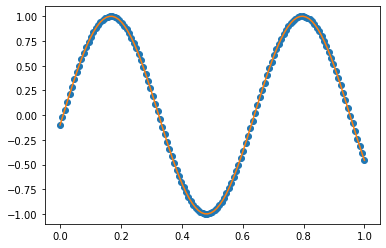

In [30]:
xt = []
yt = []
for i in range(grid_a.size):
  xt.append(xli_cpu(grid_l[i], grid_i[i]))
  yt.append(fun_cpu(xli_cpu(grid_l[i], grid_i[i])))

y = [fun_cpu(x) for x in np.linspace(0,1,100)]
plt.plot(xt, yt, 'o')
x = np.linspace(0,1,100)
plt.plot(x, y)
plt.show()

d = 3 пробуем реализовать

In [3]:
grid_levels = [1,2,3,5,7]
grid_level = 3
basis_dimensions = [1,2,4] # basis dimension
basis_dimension = 2 # basis dimension
gridTypes = ['full', 'sparse']
gridType = 'full'
n_points = 10
func_dimension = 3  # function dimension

In [4]:
@cuda.jit('float64(float64[:])', device=True)
def fun_gpu3(x):
    return math.sin(5 * x[0]) + math.cos(6 * x[1]) + 0.01 * math.sin(10 * x[0] * x[1])

def fun_cpu3(x):
    return math.sin(5 * x[0]) + math.cos(6 * x[1]) + 0.01 * math.sin(10 * x[0] * x[1])

In [5]:
@cuda.jit('float64(int32, int32)', device=True)
def xli_gpu(l, i):
    return i * (2. ** (-l))

def xli_cpu(l, i):
    return i * (2. ** (-l))

In [6]:
@cuda.jit('float64(float64)', device=True)
def phi_1(x):
    if -1 <= x <= 1:
        return 1 - abs(x)
    return 0

@cuda.jit('float64(float64)', device=True)
def phi_2(x):
    if -1 <= x <= 1:
        return - (x-1)*(x+1)
    return 0

@cuda.jit('float64(float64)', device=True)
def phi_4_1(x):
    if -1 <= x <= 3:
        return - 1/6 * (x+1)*(x-1)*(x-2)*(x-3)
    return 0

@cuda.jit('float64(float64)', device=True)
def phi_4_2(x):
    if -3 <= x <= 1:
        return - 1/6 * (x+3)*(x+2)*(x+1)*(x-1)
    return 0

@cuda.jit('float64(int32, int32, float64, int32)', device=True)
def phi_li_1(l, i, x, db):
    if db == 1:
        return phi_1(x * 2 ** l - i)
    return 0

@cuda.jit('float64(int32, int32, float64, int32)', device=True)
def phi_li_2(l, i, x, db):
        if l == 0:
            return phi_1(x * 2 ** l - i)
        else:
            return phi_2(x * 2 ** l - i)

@cuda.jit('float64(int32, int32, float64, int32)', device=True)
def phi_li_4(l, i, x, db):
    if l == 0:
        return phi_1(x * 2 ** l - i)
    elif l == 1:
        return phi_2(x * 2 ** l - i)
    elif i % 4 == 1:
        return phi_4_1(x * 2 ** l - i)
    elif i % 4 == 3:
        return phi_4_2(x * 2 ** l - i)
    return 0

@cuda.jit('float64(int32, int32, float64, int32)', device=True)
def phi_li_gpu3(l, i, x, db):
  if db == 1:
    return phi_li_1(l, i, x, db)
  if db == 2:
    return phi_li_2(l, i, x, db)
  if db == 4:
    return phi_li_4(l, i, x, db)
  return 0

In [7]:
def add_a3(e, bdim, fdim):
    if bdim == 1:
        e['a'] =  alik_1d(e['l'], e['i'], 0, fdim)
    if bdim == 2:
        e['a'] =  alik_2d(e['l'], e['i'], 0, fdim)
    if bdim == 4:
        e['a'] =  alik_4d(e['l'], e['i'], 0, fdim)
    return e

def alik_1d(l, i, k, fdim):
    if k == fdim:
        x = [xli_cpu(l[j], i[j]) for j in range(fdim)]
        return fun_cpu3(x)
    else:
        main_val = alik_1d(l,i,k+1, fdim)

        if (i[k] > 0 ) and l[k] > 0:  
            i_prev_1 = [val-1 if idx == k else val for idx, val in enumerate(i)]
            i_next_1 = [val+1 if idx == k else val for idx, val in enumerate(i)]
            return main_val - 0.5*(alik_1d(l,i_prev_1,k+1, fdim) + alik_1d(l,i_next_1,k+1, fdim))
        else:
            return main_val
        
def alik_2d(l, i, k, fdim):
    if k == fdim:
        x = [xli_cpu(l[j], i[j]) for j in range(fdim)]
        return fun_cpu3(x)
    else:
        main_val = alik_2d(l,i,k+1,fdim)

        if l[k] == 1 and i[k] > 0:
            i_prev_1 =  [val-1 if idx == k else val for idx, val in enumerate(i)]
            i_next_1 =  [val+1 if idx == k else val for idx, val in enumerate(i)]
            return main_val - 0.5 * (alik_2d(l,i_prev_1,k+1, fdim) + alik_2d(l,i_next_1,k+1, fdim))
        
        if l[k] > 1:
            i_prev_1 = [val-1 if idx == k else val for idx, val in enumerate(i)]
            i_next_1 = [val+1 if idx == k else val for idx, val in enumerate(i)]

            prev_1_val = alik_2d(l,i_prev_1,k+1, fdim)
            next_1_val = alik_2d(l,i_next_1,k+1, fdim)
            
            if (i[k] % 4 == 1):
                i_next_3 = [val+3 if idx == k else val for idx, val in enumerate(i)]
                next_3_val = alik_2d(l,i_next_3,k+1, fdim)
                return main_val - 0.125*(3*prev_1_val+6*next_1_val-next_3_val)
            
            if (i[k] % 4 == 3):
                i_prev_3 = [val-3 if idx == k else val for idx, val in enumerate(i)]
                prev_3_val = alik_2d(l,i_prev_3,k+1, fdim)
                return main_val - 0.125*(6*prev_1_val+3*next_1_val-prev_3_val)
        return main_val

def alik_4d(l, i, k, fdim):

    if k == fdim:
        x = [xli_cpu(l[j], i[j]) for j in range(fdim)]
        return fun_cpu3(x)
    else:
        main_val = alik_4d(l,i,k+1,fdim)
        i_prev_1 = [val-1 if idx == k else val for idx, val in enumerate(i)]
        i_next_1 = [val+1 if idx == k else val for idx, val in enumerate(i)]
        
        i_prev_3 = [val-3 if idx == k else val for idx, val in enumerate(i)]
        i_next_3 = [val+3 if idx == k else val for idx, val in enumerate(i)]
        
        i_prev_5 = [val-5 if idx == k else val for idx, val in enumerate(i)]
        i_next_5 = [val+5 if idx == k else val for idx, val in enumerate(i)]
        
        i_prev_7 = [val-7 if idx == k else val for idx, val in enumerate(i)]
        i_next_7 = [val+7 if idx == k else val for idx, val in enumerate(i)]

        if l[k] == 1 and i[k] > 0 :
            return main_val - 0.5 * ( alik_4d(l,i_prev_1,k+1, fdim) + alik_4d(l,i_next_1,k+1, fdim) )
        
        if l[k] == 2:
            prev_1_val = alik_4d(l,i_prev_1,k+1, fdim)
            next_1_val = alik_4d(l,i_next_1,k+1, fdim)
            
            if (i[k] % 4 == 1):
                next_3_val = alik_4d(l,i_next_3,k+1, fdim)
                return main_val - 0.125 * (3*prev_1_val + 6*next_1_val - next_3_val)
            
            if (i[k] % 4 == 3):
                prev_3_val = alik_4d(l,i_prev_3,k+1, fdim)
                return main_val - 0.125 * (6*prev_1_val + 3*next_1_val - prev_3_val)
        
        if l[k] > 2: 
            
            prev_1_val = alik_4d(l,i_prev_1,k+1, fdim)
            next_1_val = alik_4d(l,i_next_1,k+1, fdim)
            prev_3_val = alik_4d(l,i_prev_3,k+1, fdim)
            next_3_val = alik_4d(l,i_next_3,k+1, fdim)
            
            if (i[k] % 8 == 1):
                next_5_val = alik_4d(l,i_next_5,k+1, fdim)
                next_7_val = alik_4d(l,i_next_7,k+1, fdim)
                return main_val - 1/128 * (35*prev_1_val + 140*next_1_val - 70*next_3_val + 28*next_5_val - 5*next_7_val)
            
            elif (i[k] % 8 == 3):
                next_5_val = alik_4d(l,i_next_5,k+1, fdim)
                return main_val - 1/128 * (-5*prev_3_val + 60*prev_1_val + 90*next_1_val - 20*next_3_val + 3*next_5_val)
            
            elif (i[k] % 8 == 5):
                prev_5_val = alik_4d(l,i_prev_5,k+1, fdim)
                return main_val - 1/128 * (3*prev_5_val - 20*prev_3_val + 90*prev_1_val + 60*next_1_val - 5*next_3_val)
            
            elif (i[k] % 8 == 7):
                prev_5_val = alik_4d(l,i_prev_5,k+1, fdim)
                prev_7_val = alik_4d(l,i_prev_7,k+1, fdim)
                return main_val - 1/128 * (-5*prev_7_val + 28*prev_5_val - 70*prev_3_val + 140*prev_1_val + 35*next_1_val)
            
        return main_val

# Generate grid

In [8]:
def buildGrid(grid_level, type, bdim,  fdim):
    print('grid_level:', grid_level)
    grid=[]
    x = [0,0]
    for ii in range(1 << fdim):
        l = [(ii >> j) & 1 for j in range(fdim)]
        z = [j for j in range(fdim) if l[j] == 0]
        i = [1] * fdim
        for jj in range(1 << len(z)):
            i = i[:]
            for j in range(len(z)):
                 i[z[j]] = (jj >> j) & 1
            grid.append(add_a3({'l': l, 'i': i.copy()}, bdim, fdim))
            
        for e in grid:
            l = e['l']
            if sum(l) == grid_level + fdim - 1 or abs(e['a']) < 1e-3 and type == 'sparse':
                continue
            for j in range(fdim):
                if l[j] == 0:
                    continue
                i = e['i']
                child_1 = add_a3({'l': l[:j] + [l[j] + 1] + l[j + 1:], 'i': i[:j] + [2 * i[j] - 1] + i[j + 1:]}, bdim, fdim)
                child_2 = add_a3({'l': l[:j] + [l[j] + 1] + l[j + 1:], 'i': i[:j] + [2 * i[j] + 1] + i[j + 1:]}, bdim, fdim)
                if child_1 not in grid:
                    grid.append(child_1)
                if child_2 not in grid:
                    grid.append(child_2)
    return grid.copy()

# Prepare grid for GPU

In [9]:
def prepareGrid(grid, fdim):
  grid_l = []
  grid_i = []
  grid_a = []

  for i in grid:
    grid_l.append(i['l'])
    grid_i.append(i['i'])
    grid_a.append(i['a'])
  
  grid_l = np.array(grid_l)
  grid_i = np.array(grid_i)
  grid_a = np.array(grid_a)

  if fdim > 1:
    grid_l = grid_l.reshape(-1,fdim)
    grid_i = grid_i.reshape(-1,fdim)
    grid_a = grid_a
  return grid_l, grid_i, grid_a

# Eval

In [24]:
@cuda.jit('void(int32[:,:], int32[:,:], float64[:], float64[:, :, :], float64[:, :], int32, int32)')
def eval_gpu3(grid_l, grid_i, grid_a, phi, a, x, fdim, bd):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # Отображение потока на индекс массива
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y # Отображение потока на индекс массива
    z = cuda.blockIdx.z * cuda.blockDim.z + cuda.threadIdx.z # Отображение потока на индекс массива

    if (i >= phi.shape[0]) or (j >= phi.shape[1]) or (z >= phi.shape[2]) :
      return
    phi[i][j][z] = phi_li_gpu3(grid_l[j][z], grid_i[j][z], x[i][z], bd)

In [12]:
grid = buildGrid(grid_level, gridType, basis_dimension, func_dimension)
grid_l, grid_i, grid_a = prepareGrid(grid,func_dimension)

grid_level: 3


In [13]:
grid_l.shape, grid_i.shape, grid_a.shape

((705, 3), (705, 3), (705,))

In [50]:
from numba import cuda # Библиотека Nvidia для работы с GPU 
import numpy as np 

def run(n, x, f_dim, bd):
  # Перенос с хоста на устройство
  d_grid_l = cuda.to_device(grid_l)  # Перенос данных в глобальную память GPU
  d_grid_i = cuda.to_device(grid_i)  # Перенос данных в глобальную память GPU
  d_grid_a = cuda.to_device(grid_a)  # Перенос данных в глобальную память GPU
  d_r = cuda.device_array_like(np.zeros(n))
  d_x = cuda.to_device(x)

  tpb = (16, 16, 4)  #blocksize или количество потоков на блок, стандартное значение = 32
  bpg = (int(np.ceil((n[0])/tpb[0])), int(np.ceil((n[1])/tpb[1])), int(np.ceil((n[2])/tpb[2])),)  # блоков на грид

  eval_gpu3[bpg, tpb](d_grid_l, d_grid_i, d_grid_a, d_r, x, f_dim, bd) # вызов ядра

  #Перенос вывода с устройства на хост
  r = d_r.copy_to_host()
  a_for_point = np.array([grid_a for i in x])
  return np.sum(np.multiply(np.prod(r, axis=2), b), axis=1)

In [51]:
x = []
for i in np.linspace(0., 1., num=n_points):
  for j in np.linspace(0., 1., num=n_points):
    for k in np.linspace(0., 1., num=n_points):
      x.append([i,j,k])
x = np.array(x)

n = [x.shape[0], grid_a.size, x.shape[1]]
r = run(n, x, func_dimension, basis_dimension)

In [52]:
%timeit run(n, x, func_dimension, basis_dimension)

10 loops, best of 5: 30.2 ms per loop


In [48]:
r[20:40]

array([ 0.23535409,  0.23535409,  0.23535409,  0.23535409,  0.23535409,
        0.23535409,  0.23535409,  0.23535409,  0.23535409,  0.23535409,
       -0.41643563, -0.41643563, -0.41643563, -0.41643563, -0.41643563,
       -0.41643563, -0.41643563, -0.41643563, -0.41643563, -0.41643563])

In [28]:
x = []
for i in np.linspace(0., 1., num=n_points):
  for j in np.linspace(0., 1., num=n_points):
    for k in np.linspace(0., 1., num=n_points):
      x.append([i,j,k])
x = np.array(x)
x.shape[0]

1000

In [30]:
a = np.array([1,2,3])
b = np.array([2,3,4])
np.multiply(a,b)

array([ 2,  6, 12])

In [29]:
np.zeros(n[1:3]).shape

(705, 3)

In [30]:
n = [x.shape[0], grid_a.size, x.shape[1]]
tpb = (32, 32, func_dimension)  #blocksize или количество потоков на блок, стандартное значение = 32
bpg = (int(np.ceil((n[0])/tpb[0])), int(np.ceil((n[1])/tpb[1])), int(np.ceil((n[2])/tpb[2])) )  # блоков на грид
n, tpb, bpg

([1000, 705, 3], (32, 32, 3), (32, 23, 1))